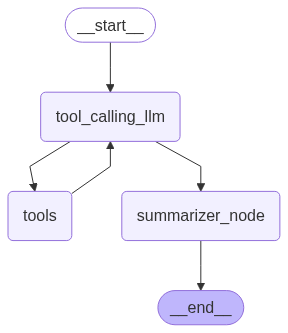

In [2]:
from typing import Annotated
import os
from dotenv import load_dotenv
from langchain_tavily import TavilySearch
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_google_genai import ChatGoogleGenerativeAI

load_dotenv()

groq_key = os.getenv('groq_api_key')
gemini_key = os.getenv('gemini_api_key')

llm = ChatGroq(
    model = "deepseek-r1-distill-llama-70b",
    api_key= groq_key,
    temperature= 0.6
)

llm2 = ChatGoogleGenerativeAI(
    model = "gemini-2.5-flash",
    api_key = gemini_key,
    temperature = 0.6
)

tool = TavilySearch(max_results = 2)
tools = [tool]

memory = MemorySaver()

llm_with_tool = llm.bind_tools(tools)

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# ReAct Agent
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}

def summarizer_node(state: State):
    return {"messages": [llm2.invoke(state["messages"])]}

graph_builder.add_node("tool_calling_llm", tool_calling_llm)
graph_builder.add_node("tools", ToolNode(tools))
graph_builder.add_node("summarizer_node", summarizer_node) 
graph_builder.add_edge(START, "tool_calling_llm")
graph_builder.add_edge("tool_calling_llm","tools")
graph_builder.add_edge("tools", "tool_calling_llm")
graph_builder.add_edge("tool_calling_llm", "summarizer_node") 
graph_builder.add_edge("summarizer_node", END)
graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

# response = graph.invoke({"messages":"tell me the recent ai news and tell me news about indian defence"})

# for m in response['messages']:
#     m.pretty_print()



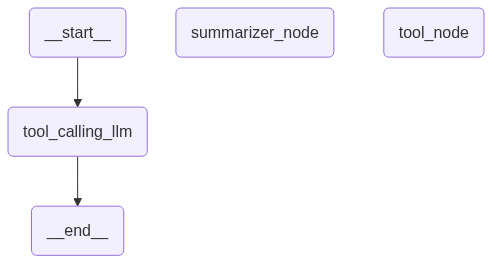

---
tell me the recent ai news and tell me news about indian defence
---

---
{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://nypost.com/2025/07/02/business/chinese-tech-firms-are-gaining-fast-on-silicon-valley-in-ai-race-report/", "title": "Chinese tech firms are gaining fast on Silicon Valley in AI race: report - nypost.com", "score": 0.70287734, "published_date": "Wed, 02 Jul 2025 18:39:00 GMT", "content": "Global banking giants HSBC and Standard Chartered have launched internal testing of the Chinese model, while Saudi Aramco, the world’s largest oil company, recently installed the bot in its main data center, according to the Journal.\n\nAmerican tech giants like Amazon Web Services, Microsoft and Google offer DeepSeek to customers – even as the Trump administration has banned the use of the Chinese model on government devices.", "raw_content": null}, {"url": "https://opentools.ai/news/elon-musks-xai-secures-a-who

In [5]:
from typing import Annotated
import os
from dotenv import load_dotenv
from langchain_tavily import TavilySearch
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition # Can keep for general knowledge, but we'll use a lambda
from langchain_google_genai import ChatGoogleGenerativeAI

load_dotenv()

groq_key = os.getenv('groq_api_key')
gemini_key = os.getenv('gemini_api_key')

llm = ChatGroq(
    model = "deepseek-r1-distill-llama-70b",
    api_key= groq_key,
    temperature= 0.6
)

llm2 = ChatGoogleGenerativeAI(
    model = "gemini-2.5-flash",
    api_key = gemini_key,
    temperature = 0.6
)

tool = TavilySearch(max_results = 2)
tools = [tool]

llm_with_tool = llm.bind_tools(tools)

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# ReAct Agent
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}

def summarizer_node(state: State):
    last_msg = state["messages"][-1].content
    # It's crucial here that last_msg actually contains content if it's meant to be summarized.
    # If the LLM generates only tool_calls and then stops, last_msg.content will be empty.
    # We should ensure summarizer_node only receives content it can summarize.
    if not last_msg:
        # If no content, it means the tool_calling_llm might have only suggested tools
        # or it's an intermediary message without a direct answer.
        # This path might need more careful handling depending on desired behavior.
        # For now, let's return messages as-is, potentially leading to an empty summary.
        return {"messages": state["messages"]}

    prompt = f"Summarize this and return in neat JSON format:\n\n{last_msg}"
    result = llm2.invoke(prompt)
    return {"messages": state["messages"] + [result]}

# Define the ToolNode
tool_node = ToolNode(tools)

graph_builder.add_node("tool_calling_llm", tool_calling_llm)
graph_builder.add_node("summarizer_node", summarizer_node)
graph_builder.add_node("tool_node", tool_node)

graph_builder.add_edge(START, "tool_calling_llm")

# --- CORRECTED CONDITIONAL EDGES BASED ON DOCUMENTATION PATTERNS ---
graph_builder.add_conditional_edges(
    "tool_calling_llm",
    # The condition function. It should return a string key corresponding to the next node.
    # If the LLM's response has tool_calls, go to 'tool_node'.
    # Otherwise, it's considered a direct response, so go to 'summarizer_node'.
    lambda state: "tool_node" if state["messages"][-1].tool_calls else "summarizer_node"
)

# After tool execution, always return to the tool_calling_llm to process tool results
graph_builder.add_edge("tool_node", "tool_calling_llm")

# The summarizer_node is the final step before ending
graph_builder.add_edge("summarizer_node", END)

graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

response = graph.invoke({"messages":"tell me the recent ai news and tell me news about indian defence"})

for m in response["messages"]:
    print("---")
    print(m.content)